When will I win the Great Bear Run?
-----------------------------------------

This notebook presents an application of Bayesian inference to predicting the outcome of a road race.

Copyright 2016 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

from thinkbayes2 import Pmf, Cdf, Beta

import thinkbayes2
import thinkplot

import numpy as np
from scipy import stats

%matplotlib inline

[Last year I wrote about my chances of winning my age group in a 5K](http://allendowney.blogspot.com/2015/10/when-will-i-win-great-bear-run.html).  This is an update to that article, based on new data.

Almost every year since 2008 I have participated in the Great Bear Run, a 5K road race in Needham MA.  I usually finish in the top 30 or so, and in my age group I have come in 2nd, 3rd, 4th (three times), 5th, and 6th.

So I have to wonder if I'll ever win my age group.  To answer this question, I developed a Bayesian model of road racing.

### The SOB model

To understand the model, it helps to look at the data.  Here is the list of people who beat me in each race:

In [2]:
data = {
    2008: ['Gardiner', 'McNatt', 'Terry'],
    2009: ['McNatt', 'Ryan', 'Partridge', 'Turner', 'Demers'],
    2010: ['Gardiner', 'Barrett', 'Partridge'],
    2011: ['Barrett', 'Partridge'],
    2012: ['Sagar'],
    2013: ['Hammer', 'Wang', 'Hahn'],
    2014: ['Partridge', 'Hughes', 'Smith'],
    2015: ['Barrett', 'Sagar', 'Fernandez'],
    2016: ['McGrane', 'Davies', 'Partridge', 'Johnson'],
}

There are some regulars who show up and beat me almost every year, but they are not always in my age group.  But there are other names that appear only once.

To predict my performance in future races, we need a model that includes the probability that regulars will show up, and well as the possibility that newcomers will appear.

I model this process with three factors, $S$, $O$, and $B$.  In order to finish ahead of me, a runner has to

1. **S**how up,
2. **O**utrun me, and
3. **B**e in my age group.

For each runner, the probability of displacing me is a product of these factors:

$p_i = SOB$

Some runners have a higher SOB factor than others; we can use previous results to estimate it.

But first we have to think about an appropriate prior.  Based on casual observation, I conjecture that the prior distribution of $S$ is an increasing function, with many people who run nearly every year, and fewer who run only occasionally:

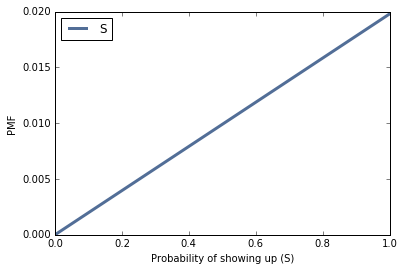

In [3]:
ss = Beta(2, 1)
thinkplot.Pdf(ss.MakePmf(), label='S')
thinkplot.Config(xlabel='Probability of showing up (S)',
                 ylabel='PMF', loc='upper left')

The prior distribution of $O$ is biased toward high values.  Of the people who have the potential to beat me, many of them will beat me every time.  I am only competitive with a few of them.

(For example, of the 18 people who have beat me, I have only ever beat 2).

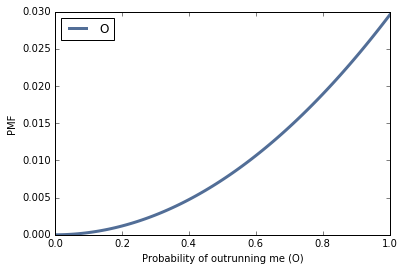

In [4]:
os = Beta(3, 1)
thinkplot.Pdf(os.MakePmf(), label='O')
thinkplot.Config(xlabel='Probability of outrunning me (O)',
                 ylabel='PMF', loc='upper left')

The probability that a runner is in my age group depends on the difference between his age and mine.  Someone exactly my age will always be in my age group.  Someone 4 years older will be in my age group only once every 5 years (the Great Bear run uses 5-year age groups).

So the distribution of $B$ is uniform.

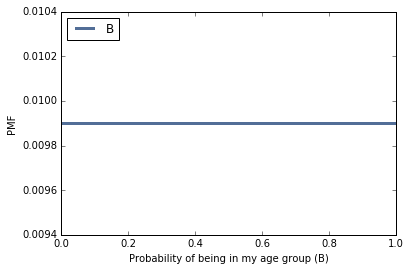

In [5]:
bs = Beta(1, 1)
thinkplot.Pdf(bs.MakePmf(), label='B')
thinkplot.Config(xlabel='Probability of being in my age group (B)',
                 ylabel='PMF', loc='upper left')

I used Beta distributions for each of the three factors, so each $p_i$ is the product of three Beta-distributed variates.  In general, the result is not a Beta distribution, but maybe we can find a Beta distribution that is a good approximation of the actual distribution.

I'll draw a sample from the distributions of $S$, $O$, and $B$, and multiply them out. It turns out that the result is a good match for a Beta distribution with parameters 1 and 3.

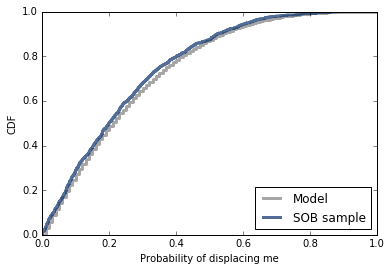

In [6]:
n = 1000
sample = ss.Sample(n) * os.Sample(n) * bs.Sample(n)
cdf = Cdf(sample)

thinkplot.PrePlot(1)

prior = Beta(1, 3)
thinkplot.Cdf(prior.MakeCdf(), color='grey', label='Model')
thinkplot.Cdf(cdf, label='SOB sample')
thinkplot.Config(xlabel='Probability of displacing me',
                 ylabel='CDF', loc='lower right')

Now let's look more carefully at the data.  There are 18 people who have beat me during at least one year, several more than once.

The runner with the biggest SOB factor is Rich Partridge, who has displaced me in 5 of 9 years.  In fact, he outruns me almost every year, but is not always in my age group.

In [7]:
from itertools import chain
from collections import Counter

counter = Counter(chain(*data.values()))
len(counter), counter

(18,
 Counter({'Barrett': 3,
          'Davies': 1,
          'Demers': 1,
          'Fernandez': 1,
          'Gardiner': 2,
          'Hahn': 1,
          'Hammer': 1,
          'Hughes': 1,
          'Johnson': 1,
          'McGrane': 1,
          'McNatt': 2,
          'Partridge': 5,
          'Ryan': 1,
          'Sagar': 2,
          'Smith': 1,
          'Terry': 1,
          'Turner': 1,
          'Wang': 1}))

The following function makes a Beta distribution to represent the posterior distribution of $p_i$ for each runner.  It starts with the prior, `Beta(1, 3)`, and updates it with the number of times the runner displaces me, and the number of times he doesn't.

In [8]:
def MakeBeta(count, num_races, precount=3):
    beta = Beta(1, precount)
    beta.Update((count, num_races-count))
    return beta

Now we can make a posterior distribution for each runner:

In [9]:
num_races = len(data)
betas = [MakeBeta(count, num_races) 
         for count in counter.values()]

Let's check the posterior means to see if they make sense.  For Rich Partridge, who has displaced me 5 times out of 9, the posterior mean is 46%; for someone who has displaced me only once, it is 15%.

So those don't seem crazy.

In [10]:
[beta.Mean() * 100 for beta in betas]

[15.384615384615385,
 15.384615384615385,
 15.384615384615385,
 15.384615384615385,
 15.384615384615385,
 23.076923076923077,
 15.384615384615385,
 15.384615384615385,
 15.384615384615385,
 23.076923076923077,
 23.076923076923077,
 15.384615384615385,
 15.384615384615385,
 46.15384615384615,
 15.384615384615385,
 15.384615384615385,
 15.384615384615385,
 30.76923076923077]

Now we're ready to do some inference.  The model only has one parameter, the total number of runners who could displace me, $n$.  For the 18 SOBs we have actually observed, we use previous results to estimate $p_i$.  For additional hypothetical runners, we update the distribution with 0 displacements out of `num_races`.

To improve performance, my implementation precomputes the distribution of $k$ for each value of $n$, using `ComputePmfs` and `ComputePmf`.

After that, the `Likelihood` function is simple: it just looks up the probability of $k$ given $n$.

In [11]:
class Bear2(thinkbayes2.Suite, thinkbayes2.Joint):

    def ComputePmfs(self, data):
        num_races = len(data)
        counter = Counter(chain(*data.values()))
        betas = [MakeBeta(count, num_races) 
                 for count in counter.values()]
        
        self.pmfs = dict()
        low = len(betas)
        high = max(self.Values())
        for n in range(low, high+1):
            self.pmfs[n] = self.ComputePmf(betas, n, num_races)
    
    def ComputePmf(self, betas, n, num_races, label=''):
        no_show = MakeBeta(0, num_races)
        all_betas = betas + [no_show] * (n - len(betas))
        
        ks = []
        for i in range(2000):
            ps = [beta.Random() for beta in all_betas]
            xs = np.random.random(len(ps))
            k = sum(xs < ps)
            ks.append(k)
            
        return Pmf(ks, label=label)
    
    def Likelihood(self, data, hypo):
        n = hypo
        k = data
        return self.pmfs[n][k]
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for n, prob in self.Items():
            pmf = bear2.pmfs[n]
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

Here's what some of the precomputed distributions look like, for several values of $n$.

If there are fewer runners, my chance of winning is slightly better, but the difference is small, because fewer runners implies a higher mean for $p_i$.

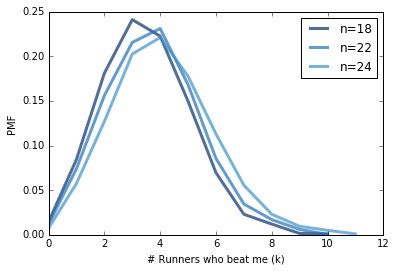

In [12]:
bear2 = Bear2()

thinkplot.PrePlot(3)
pmf = bear2.ComputePmf(betas, 18, num_races, label='n=18')
pmf2 = bear2.ComputePmf(betas, 22, num_races, label='n=22')
pmf3 = bear2.ComputePmf(betas, 26, num_races, label='n=24')
thinkplot.Pdfs([pmf, pmf2, pmf3])
thinkplot.Config(xlabel='# Runners who beat me (k)',
                 ylabel='PMF', loc='upper right')

For the prior distribution of $n$, I'll use a uniform distribution from 18 to 40.

In [13]:
low = 18
high = 40
bear2 = Bear2(range(low, high))
bear2.ComputePmfs(data)

And here's the update, using the number of runners who displaced me each year:

In [14]:
for year, sobs in data.items():
    k = len(sobs)
    bear2.Update(k)

Here's the posterior distribution of $n$.  It's noisy because I used random sampling to estimate the conditional distributions of $k$.  But that's ok because we don't really care about $n$; we care about the predictive distribution of $k$.  And noise in the distribution of $n$ has very little effect on $k$.

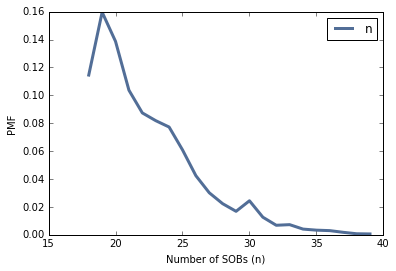

In [15]:
thinkplot.PrePlot(1)
thinkplot.Pdf(bear2, label='n')
thinkplot.Config(xlabel='Number of SOBs (n)',
                 ylabel='PMF', loc='upper right')

The predictive distribution for $k$ is a weighted mixture of the conditional distributions we already computed:

In [16]:
predict = bear2.Predict()

And here's what it looks like:

1.3229375957878466

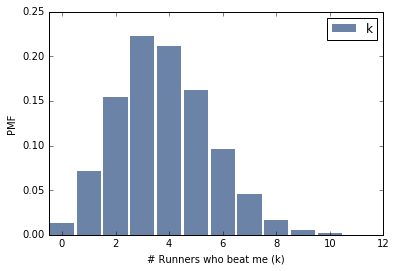

In [17]:
thinkplot.Hist(predict, label='k')
thinkplot.Config(xlabel='# Runners who beat me (k)', ylabel='PMF', xlim=[-0.5, 12])
predict[0] * 100

According to this model, my chance of winning my age group is less than 2%.  Disappointing.  